In [1]:
from enum import Enum, auto
import networkx as nx
from networkx.generators.classic import complete_graph
from networkx.generators.random_graphs import watts_strogatz_graph
from math import floor, ceil
import numpy as np
from random import choices, sample, random
import matplotlib.pyplot as plt

N_NODES = 934
K = 10
BETA = 0.3
RHO = 0.6
P = 0.2
DK = 1
DBETA = 0.1
DRHO = 0.1
DP = 0.05
N_WEEKS = 15
N = 10
VACC = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60] # first index is initial state
I0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

class State(Enum):
    # enum type for representing SIR states
    SUSCEPTIBLE = auto()
    INFECTED = auto()
    RECOVERED = auto()
    VACCINATED = auto()
    
class Simulation:
    def __init__(self, network, initially_vaccinated, initially_infected=None):
        """
        if initially_infected and initially_vaccinated overlap, vaccination has the advantage
        """
        self.network = network # should be RandomGraph underlying graph
        self.weeks = []
        self.weeks.append([State.SUSCEPTIBLE]*N_NODES)
        if initially_infected is None:
            initially_infected = sample(range(N_NODES), k=10)       
        for node in initially_infected:
            self.weeks[0][node] = State.INFECTED # self.weeks[0] represents initial state
        for node in initially_vaccinated:
            self.weeks[0][node] = State.VACCINATED
            
    def simulate(self, n_weeks=N_WEEKS, beta=BETA, rho=RHO):
        for time in range(1,n_weeks+1):
            self.weeks.append([State.SUSCEPTIBLE]*N_NODES)
            for node in range(N_NODES):
                old_state = self.weeks[time-1][node]
                if old_state == State.SUSCEPTIBLE:
                    m = [self.weeks[time-1][neigh] for neigh in self.network.neighbors(node)].count(State.INFECTED)
                    new_state = State.INFECTED if random() < 1 - (1-beta)**m else State.SUSCEPTIBLE
                    self.weeks[time][node] = new_state
                elif old_state == State.INFECTED:
                    new_state = State.RECOVERED if random() < rho else State.INFECTED
                    self.weeks[time][node] = new_state
                else:
                    self.weeks[time][node] = self.weeks[time-1][node]
                    
            ## VACCINATION
            vacc_rate = (VACC[time] - VACC[time-1])/100
            n_people_to_vaccinate = int(N_NODES * vacc_rate)
            people_to_vaccinate = sample(
                [node for node in range(N_NODES) if self.weeks[time][node] != State.VACCINATED],
                    k=n_people_to_vaccinate)
            for node in people_to_vaccinate:
                self.weeks[time][node] = State.VACCINATED
                
def remove_with_predicate(predicate, l):
    return [e for e in l if predicate(e)]
                
def gradient_step(k0, beta0, rho0, p0, dk, dbeta, drho, dp, with_fixed_k = False):
    # can go wrong if beta or rho or p not \in [0, 1]
    ks = remove_with_predicate(lambda x : x > 0,
            [k0-dk, k0, k0+dk] if not with_fixed_k else [k0])
    betas = remove_with_predicate(lambda x : (not np.isclose(x, 0)) and x > 0 and x < 1 and (not np.isclose(x,1)),
        [beta0 - dbeta, beta0, beta0 + dbeta])
    rhos = remove_with_predicate(lambda x : (not np.isclose(x, 0)) and x > 0 and x < 1 and (not np.isclose(x,1)),
        [rho0 - drho, rho0, rho0 + drho])
    ps = remove_with_predicate(lambda x : (not np.isclose(x, 0)) and x > 0 and x < 1 and (not np.isclose(x,1)),
        [p0 -dp, p0, p0+dp])
    results = {}
    
    print("Beginning of the gradient step")
    print("Initial parameters (k, beta, rho, p):", k0, beta0, rho0, p0)
    print("With step (dk, dbeta, drho, dp) :", dk, dbeta, drho, dp)
    print("")
    
    for k in ks:
        for beta in betas:
            for rho in rhos:
                for p in ps:
                    
                    

                    infec = []
                    for _ in range(N):
                        network = watts_strogatz_graph(N_NODES, k, p)

                        initially_infected = sample(range(N_NODES), k=1) # there's a single infection at the beginning
                        vaccination_candidates = [node for node in range(N_NODES) if node != initially_infected[0]]
                        initially_vaccinated = sample(vaccination_candidates, k = int(VACC[0]* N_NODES / 100)  )  
                        s = Simulation(network, initially_vaccinated, initially_infected)
                        s.simulate(beta=beta, rho=rho)
                        weeks = s.weeks
                        infec.append([len([node for node in range(N_NODES) if weeks[time-1][node]==State.SUSCEPTIBLE and weeks[time][node]==State.INFECTED]) for time in range(1,len(weeks))])

                    infec = np.array(infec)
                    I = np.mean(infec, axis = 0)
                    score = RMSE(I)

                    results[(k, beta, rho, p)] = score
                
    best_params = min(results, key = lambda k : results[k])
                
    print("End of the gradient step")
    print("Best parameters (k, beta, rho, p):", best_params)
    print("With RMSE =", results[best_params])
    print("\n\n")  
    
    return best_params
    
    
def RMSE(I):
    # we compute RMSE beginning from week 1
    return np.sqrt(np.sum((I-I0[1:])**2)/N_WEEKS)

def gradient_search(k0 = K, beta0 = BETA, rho0 = RHO, p0 = P, dk = DK, dbeta = DBETA, drho = DRHO, dp = DP, with_fixed_k=False):
    old_k, old_beta, old_rho, old_p = k0, beta0, rho0, p0
    (new_k, new_beta, new_rho, new_p) = gradient_step(old_k, old_beta, old_rho, old_p, dk, dbeta, drho, dp)
    while not all(np.isclose((old_k, old_beta, old_rho, old_p), (new_k, new_beta, new_rho, new_p))):
        old_k, old_beta, old_rho, old_p = new_k, new_beta, new_rho, new_p
        (new_k, new_beta, new_rho, new_p) = gradient_step(old_k, old_beta, old_rho, old_p, dk, dbeta, drho, dp, with_fixed_k)
    return (new_k, new_beta, new_rho, new_p)

def check_simulation(best_k, best_beta, best_rho, best_p):
    n_simulations = 100
    infec = []

    

    for _ in range(n_simulations):
        network = watts_strogatz_graph(N_NODES, best_k, best_p)
        initially_infected = sample(range(N_NODES), k=1)
        vaccination_candidates = [node for node in range(N_NODES) if node != initially_infected[0]]
        initially_vaccinated = sample(vaccination_candidates, k = int(VACC[0]* N_NODES / 100)  )  
        s = Simulation(network, initially_vaccinated, initially_infected)
        s.simulate(beta=best_beta, rho=best_rho)
        weeks = s.weeks
        infec.append([len([node for node in range(N_NODES) if weeks[time-1][node]==State.SUSCEPTIBLE and weeks[time][node]==State.INFECTED]) for time in range(1,len(weeks))])

    infec = np.array(infec)
    I = np.mean(infec, axis=0)

    fig = plt.figure(1, figsize=(7,7))
    ax = plt.subplot(111)

    ax.plot(range(1, N_WEEKS+1), I, label='Simulated infected nodes')
    ax.plot(range(1, N_WEEKS+1), I0[1:], label='Truly infected nodes')

    plt.title("Comparison of simulation of number of infected people and actual number infected people")
    plt.xlabel("Time in weeks")
    plt.ylabel("Number of nodes")

    ax.legend()
    print("RMSE :", RMSE(I))

Beginning of the gradient step
Initial parameters (k, beta, rho, p): 10 0.3 0.6 0.2
With step (dk, dbeta, drho, dp) : 1 0.1 0.1 0.05

End of the gradient step
Best parameters (k, beta, rho, p): (11, 0.3, 0.7, 0.2)
With RMSE = 5.892990186088327



Beginning of the gradient step
Initial parameters (k, beta, rho, p): 11 0.3 0.7 0.2
With step (dk, dbeta, drho, dp) : 1 0.1 0.1 0.05

End of the gradient step
Best parameters (k, beta, rho, p): (10, 0.3, 0.7999999999999999, 0.15000000000000002)
With RMSE = 5.7613077219210105



Beginning of the gradient step
Initial parameters (k, beta, rho, p): 10 0.3 0.7999999999999999 0.15000000000000002
With step (dk, dbeta, drho, dp) : 1 0.1 0.1 0.05

End of the gradient step
Best parameters (k, beta, rho, p): (9, 0.4, 0.8999999999999999, 0.2)
With RMSE = 6.0852827926618716



Beginning of the gradient step
Initial parameters (k, beta, rho, p): 9 0.4 0.8999999999999999 0.2
With step (dk, dbeta, drho, dp) : 1 0.1 0.1 0.05

End of the gradient step
Best par

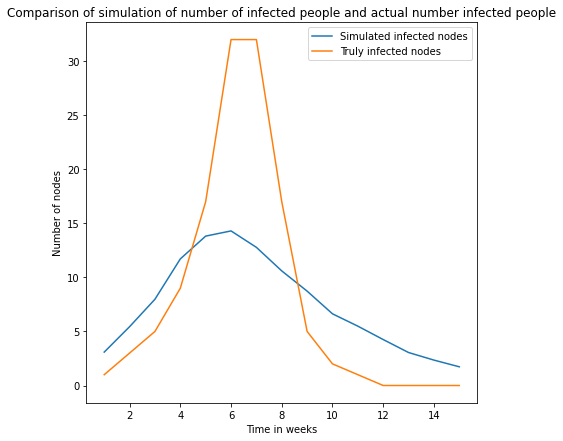

In [2]:
(best_k, best_beta, best_rho, best_p) = gradient_search()
check_simulation(best_k, best_beta, best_rho, best_p)

Beginning of the gradient step
Initial parameters (k, beta, rho, p): 8 0.4 0.8999999999999999 0.15000000000000002
With step (dk, dbeta, drho, dp) : 1 0.025 0.025 0.0125

End of the gradient step
Best parameters (k, beta, rho, p): (8, 0.4, 0.9249999999999999, 0.16250000000000003)
With RMSE = 5.568841890375412



Beginning of the gradient step
Initial parameters (k, beta, rho, p): 8 0.4 0.9249999999999999 0.16250000000000003
With step (dk, dbeta, drho, dp) : 1 0.025 0.025 0.0125

End of the gradient step
Best parameters (k, beta, rho, p): (8, 0.4, 0.95, 0.16250000000000003)
With RMSE = 5.802183497040863



Beginning of the gradient step
Initial parameters (k, beta, rho, p): 8 0.4 0.95 0.16250000000000003
With step (dk, dbeta, drho, dp) : 1 0.025 0.025 0.0125

End of the gradient step
Best parameters (k, beta, rho, p): (8, 0.42500000000000004, 0.95, 0.17500000000000004)
With RMSE = 5.162557505732987



Beginning of the gradient step
Initial parameters (k, beta, rho, p): 8 0.42500000000000

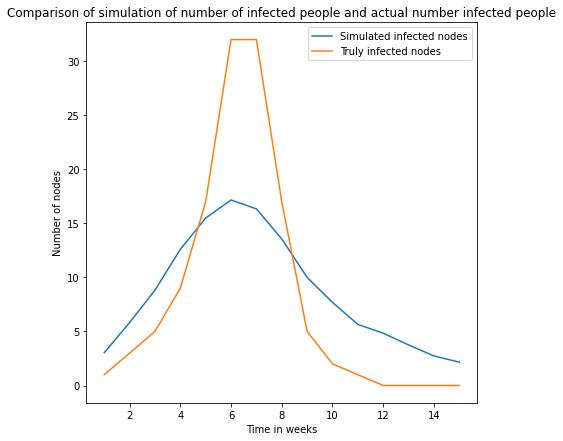

In [6]:
DK, DBETA, DRHO, DP = DK, DBETA/2, DRHO/2, DP/2
(best_k, best_beta, best_rho, best_p) = gradient_search(best_k, best_beta, best_rho, best_p, DK, DBETA, DRHO, DP, with_fixed_k=False)
check_simulation(best_k, best_beta, best_rho, best_p)